# Table of Contents

### [1. Preparations](#chapter1)

### [2. Preprocessing](#chapter2)

### [3. LDA Modeling](#chapter3)

#### [Topic visualization](#chapter3.1)

### [4. Sentiment prediction](#chapter4)

#### [4.1 Preparation](#chapter4.1)
#### [4.2 Modelling](#chapter4.2)
- [Support Vector Classifier](#chapter4.2.1)
- [Random Forest](#chapter4.2.2)
- [Logistic Regression](#chapter4.2.3)
- [Gradient Boosting](#chapter4.2.4)
- [Neural Network](#chapter4.2.5)
- [K Nearest Neighbors](#chapter4.2.6)
- [Linear Discriminant Analysis](#chapter4.2.7)

#### [4.3 Performance Summary](#chapter4.3)
- [Feature importance analysis ](#chapter4.3.1)
- [Further error analysis: misclassified texts by best model](#chapter4.3.2)

# 1. Preparation <a class="anchor" id="chapter1"></a>

In [ ]:
# !pip install spacy gensim pprint
# !python -m spacy download en_core_web_sm
# !pip install pyldavis wordcloud bokeh
# !pip install pyLDAvis
# !pip install selenium

In [ ]:
import pandas as pd
import numpy as np 
from pprint import pprint
from error_analysis import *

# For language processing
import gensim, spacy, logging, warnings
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualization
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from bokeh.io import export_png
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc

# sklearn models
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# For exporting models
from gensim.test.utils import datapath
import pickle

%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
train_data = pd.read_csv('Train_data.csv')
test_data = pd.read_csv('Test_data.csv')

In [ ]:
data = pd.concat([train_data, test_data]).reset_index(drop=True)
data

,Review,Rating,Recommended
0,zag-sxf on new a319 with clean cabin. legroom ...,8.0,1
1,"the flight was delayed by 6 hours, allegedly b...",1.0,0
2,fly an average of twice a year between north r...,7.0,1
3,str-stn return. another great flight with germ...,3.0,0
4,13th december from heathrow t2 to vienna via c...,10.0,1
...,...,...,...
123,flew best class from hamburg to cologne. best ...,9.0,1
124,hamburg to prague late monday morning. this se...,5.0,0
125,the last-minute addition of £13 for use of a c...,3.0,0
126,cgn-zrh. despite the sudden snowfall at their ...,6.0,1


# 2. Preprocessing <a class="anchor" id="chapter2"></a>
Tokenization and filtering

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [ ]:
%%time

def text_to_words(text):
    """Tokenize a text and do some prefiltering for n-gram processing.
    """
    word_list = []
    doc = nlp(text)
    for t in doc:
        if (t.is_alpha == True) and (len(t)>=2):
            word_list.append(t.lower_)
    
    return word_list

texts = data.Review.values.tolist()
texts_words = [text_to_words(text) for text in texts]
print(texts_words[:1])

[['zag', 'sxf', 'on', 'new', 'with', 'clean', 'cabin', 'legroom', 'okay', 'flight', 'attendants', 'professional', 'could', 'smile', 'bit', 'more', 'and', 'inflight', 'service', 'food', 'and', 'beverage', 'rates', 'are', 'acceptable', 'have', 'been', 'using', 'germanwings', 'several', 'times', 'per', 'year', 'and', 'find', 'them', 'reliable', 'low', 'cost', 'carrier', 'that', 'provides', 'quality', 'service', 'for', 'price', 'paid']]
Wall time: 2.03 s


In [ ]:
%%time
# Build the bigram and trigram models
# The minimum occurency of a bigram phrase should be 5
# Both the bigram and trigram phrases should have the threshold 100
bigram_phrases = gensim.models.Phrases(texts_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[texts_words], threshold=100) 

# This is a kind of technical pruning only.
bigram_phraser = gensim.models.phrases.Phraser(bigram_phrases)
trigram_phraser = gensim.models.phrases.Phraser(trigram_phrases)

Wall time: 201 ms


In [ ]:
# Apply the n-gram models to the data
texts_words = [trigram_phraser[bigram_phraser[words]] for words in texts_words]

In [ ]:
%%time
# Now we use spacy to filter based on stopwords, POS-tags and lemmatize
filtered_texts_lemmas = []

for words in texts_words:
    doc = nlp(" ".join(words))
    tagged = nlp.get_pipe("tagger")(doc)
    
    # Filter again, and keep only the lemma of tokens which are non stopwords and 
    # are either 'NOUN', 'ADJ', 'VERB' or 'ADV with regards to their part of speech tags
    lemmas = []
    pos_list = ['NOUN', 'ADJ', 'VERB', 'ADV']
    for t in tagged:
        if (t.is_stop != True) and (t.pos_ in pos_list):
            lemmas.append(t.lemma_)
    filtered_texts_lemmas.append(lemmas)

print(filtered_texts_lemmas[0])

['zag', 'sxf', 'new', 'clean', 'cabin', 'legroom', 'flight', 'attendant', 'professional', 'smile', 'bit', 'inflight', 'service', 'food', 'beverage', 'rate', 'acceptable', 'germanwing', 'time', 'year', 'find', 'reliable', 'low_cost_carrier', 'provide', 'quality', 'service', 'price', 'pay']
Wall time: 1.58 s


# 3. LDA Modeling <a class="anchor" id="chapter3"></a>

In [ ]:
%%capture
# Create Dictionary
# create a Gensim dictionary from the final "filtered_texts_lemmas"
id2word = corpora.Dictionary(filtered_texts_lemmas)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(words) for words in filtered_texts_lemmas]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                           num_topics=5,
                                           id2word=id2word,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           iterations=250,
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())

[(0,
  '0.022*"passenger" + 0.019*"bag" + 0.017*"luggage" + 0.016*"water" + '
  '0.013*"board" + 0.011*"passport" + 0.010*"hamburg" + 0.010*"tell" + '
  '0.010*"germanwing" + 0.009*"take"'),
 (1,
  '0.048*"flight" + 0.019*"germanwing" + 0.017*"service" + 0.016*"passenger" + '
  '0.013*"delay" + 0.012*"lufthansa" + 0.011*"offer" + 0.011*"hour" + '
  '0.010*"good" + 0.010*"crew"'),
 (2,
  '0.045*"flight" + 0.026*"seat" + 0.020*"good" + 0.017*"time" + 0.015*"check" '
  '+ 0.015*"friendly" + 0.013*"return" + 0.013*"fly" + 0.013*"pay" + '
  '0.013*"germanwing"'),
 (3,
  '0.021*"fly" + 0.019*"germanwing" + 0.015*"luggage" + 0.012*"airline" + '
  '0.012*"euro" + 0.009*"charge" + 0.009*"tell" + 0.009*"drink" + 0.009*"lot" '
  '+ 0.008*"free"'),
 (4,
  '0.019*"germanwing" + 0.014*"ham" + 0.010*"booking" + 0.009*"card" + '
  '0.009*"aircraft" + 0.009*"sudden" + 0.009*"mother" + 0.008*"reasonably" + '
  '0.008*"come" + 0.007*"minute"')]


In [ ]:
texts_topics_df = pd.DataFrame()

# Get main topic in each document
for topic_probs, text in zip(lda_model.get_document_topics(corpus), filtered_texts_lemmas):
    topic_num, topic_prob = max(topic_probs, key=lambda x: x[1])
    topic_dict = lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, _ in topic_dict])
    texts_topics_df = texts_topics_df.append(pd.Series([topic_num, round(topic_prob,4), topic_keywords, text]), ignore_index=True)

texts_topics_df.columns = ["topic_no", "topic_ratio", "keywords", "text"]
texts_topics_df["topic_no"] = texts_topics_df.topic_no.astype("int")
display(texts_topics_df.head(10))

,topic_no,topic_ratio,keywords,text
0,1,0.6537,"flight, germanwing, service, passenger, delay,...","[zag, sxf, new, clean, cabin, legroom, flight,..."
1,1,0.9944,"flight, germanwing, service, passenger, delay,...","[flight, delay, hour, allegedly, radar, system..."
2,1,0.4924,"flight, germanwing, service, passenger, delay,...","[fly, average, twice, year, zürich, time, fly,..."
3,2,0.9926,"flight, seat, good, time, check, friendly, ret...","[return, great, flight, germanwing, allocate, ..."
4,2,0.6123,"flight, seat, good, time, check, friendly, ret...","[heathrow, good, crew, comfortable, cabin, sho..."
5,1,0.9821,"flight, germanwing, service, passenger, delay,...","[dortmund, super, problem, air, pressure, pain..."
6,1,0.5322,"flight, germanwing, service, passenger, delay,...","[long, germanwing, route, stuttgart, surprise,..."
7,2,0.6713,"flight, seat, good, time, check, friendly, ret...","[fly, cologne, flight, divert, technical, diff..."
8,3,0.9945,"fly, germanwing, luggage, airline, euro, charg...","[wife, check, luggage, flight, person, identif..."
9,2,0.5357,"flight, seat, good, time, check, friendly, ret...","[normal, lcc, staff, friendly, price, board, o..."


In [ ]:
# Save model to disk.
temp_file = datapath("LDAmodel")
lda_model.save(temp_file)

id2word.save("id2word")

## Topic visualization <a class="anchor" id="chapter3.1"></a>

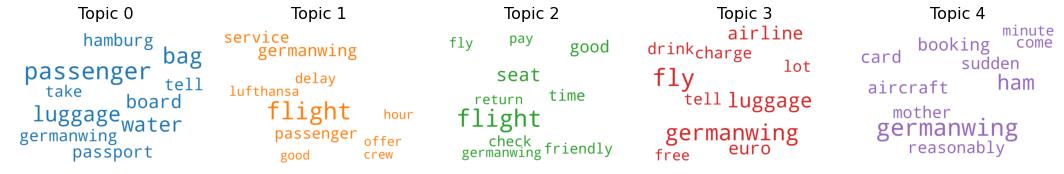

In [ ]:
# Wordcloud of Top N words in each topic
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=nlp.Defaults.stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_words=10)

fig, axes = plt.subplots(1, 5, figsize=(15,3), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    try:
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    except:
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
# plt.savefig("Wordcloud.png", pad_inches=0.05, dpi=1000)
plt.show()

In [ ]:
topic_probs = []

# Get the topic probabilities for the whole corpus from the model
for probs in lda_model.get_document_topics(corpus, minimum_probability=-1):
    topic_probs.append([prob for _, prob in probs])

# Topic probs df
df_topic_probs = pd.DataFrame(topic_probs, columns=["topic_0_prob", "topic_1_prob", "topic_2_prob", "topic_3_prob",
                                                    "topic_4_prob"
                                                    ])

# Topic weights NumPy array
arr = df_topic_probs.values

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# Fit a tSNE model
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot);

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 128 samples in 0.000s...
[t-SNE] Computed neighbors for 128 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 128 / 128
[t-SNE] Mean sigma: 0.242623
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.155735
[t-SNE] KL divergence after 1000 iterations: 0.177136


Loading BokehJS ...

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.204178  0.024765       1        1  41.879740
1      0.066484  0.142764       2        1  36.903228
3     -0.110093 -0.052552       3        1  10.650718
0     -0.154167  0.093041       4        1   7.305565
4     -0.006403 -0.208018       5        1   3.260749, topic_info=           Term       Freq      Total Category  logprob  loglift
9    germanwing  88.000000  88.000000  Default  30.0000  30.0000
88    passenger  50.000000  50.000000  Default  29.0000  29.0000
115        seat  69.000000  69.000000  Default  28.0000  28.0000
80          fly  53.000000  53.000000  Default  27.0000  27.0000
85      luggage  23.000000  23.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
165       route   0.956050  10.097204   Topic5  -5.2615   1.0660
379     operate   0.922332  10.471568   Topic5  -5.2974   0.9937
115        seat   0.981492  69.142103   Topic5  -5.2352  -0.8316
21      service   0.885090  48.878488   Topic5  -5.3386  -0.5882
726      notice   0.825693   1.922043   Topic5  -5.4081   2.5783

[328 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
953       4  0.824607    absolute
0         2  0.883582  acceptable
1225      5  0.685339     achieve
1320      5  0.685489         act
1321      5  0.685489    addition
...     ...       ...         ...
1125      1  0.927516        wine
1306      4  0.944948   wonderful
715       4  0.824600       wrong
388       3  0.478723         zrh
388       5  0.478723         zrh

[435 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1, 5])

In [ ]:
data['Topic'] = texts_topics_df['topic_no']
topic_pivot = pd.pivot_table(data, index=['Topic'], columns='Recommended', values='Rating', aggfunc='count').reset_index(drop=False)
topic_pivot.columns = ['Topic', 'Not Recommended', 'Recommended']
topic_pivot = topic_pivot.set_index("Topic")

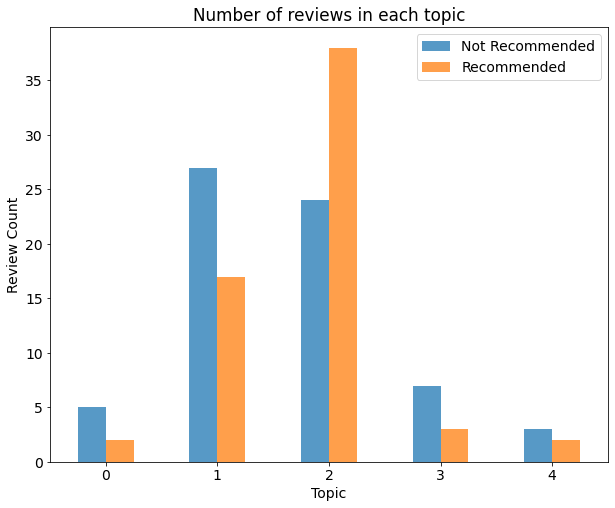

In [ ]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 14})

topic_pivot.plot.bar(rot=0, alpha=0.75)
plt.ylabel("Review Count")
plt.title("Number of reviews in each topic")

plt.savefig("Topic_distribution.png", pad_inches=0.05, dpi=1000)
plt.show()

# 4. Sentiment prediction <a class="anchor" id="chapter4"></a>

## 4.1 Preparation <a class="anchor" id="chapter4.1"></a>

In [ ]:
def plot_auc(test_df, predict_prob, model_name):
    '''
    This function returns a AUC plot that shows the relationship between
    False Positive Rate and True Positive Rate
    '''
    plt.rcParams["figure.figsize"] = (10,8)
    plt.rcParams.update({'font.size': 14})

    fpr, tpr, threshold = roc_curve(test_df.Recommended, predict_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend(loc = 'lower right')
    
    plt.xlim([0, 1]) 
    plt.ylim([0, 1]) 
    plt.ylabel('True Positive Rate') 
    plt.xlabel('False Positive Rate') 
    
    plt.title(f'ROC Curve of {model_name}')
#     plt.savefig(f"Topic_prob_{model_name}_AUC.png", pad_inches=0.1, dpi=1000)
    plt.show()
    
    return roc_auc

In [ ]:
# Create dataframe to store results of all models
summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC'])

In [ ]:
# Integrate the columns with the probabilities of each text belonging to each topic
df = pd.concat([data, df_topic_probs], axis = 1)
display(df.head())

,Review,Rating,Recommended,Topic,topic_0_prob,topic_1_prob,topic_2_prob,topic_3_prob,topic_4_prob
0,zag-sxf on new a319 with clean cabin. legroom ...,8.0,1,1,0.001472,0.653726,0.342154,0.001897,0.000751
1,"the flight was delayed by 6 hours, allegedly b...",1.0,0,1,0.000729,0.994382,0.003577,0.000940,0.000372
2,fly an average of twice a year between north r...,7.0,1,1,0.000987,0.492419,0.197987,0.308105,0.000503
3,str-stn return. another great flight with germ...,3.0,0,2,0.001182,0.004125,0.992568,0.001522,0.000603
4,13th december from heathrow t2 to vienna via c...,10.0,1,2,0.000742,0.338343,0.612277,0.048260,0.000378


In [ ]:
train_df = df.iloc[0:96, :]
test_df = df.iloc[96:, :]
X_train = train_df[["topic_0_prob", "topic_1_prob", "topic_2_prob", "topic_3_prob",
                  "topic_4_prob",]]
X_test = test_df[["topic_0_prob", "topic_1_prob", "topic_2_prob", "topic_3_prob",
                  "topic_4_prob",]]

## 4.2 Modelling <a class="anchor" id="chapter4.2"></a>
### 4.2.1 Support Vector Classifier <a class="anchor" id="chapter4.2.1"></a>

In [ ]:
param_grid = {  
              'C': [0.5,  1., 2.,  4., 8.,  10.],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] 
              }

svcmodel = SVC(random_state=0)
CV_svcmodel = GridSearchCV(estimator=svcmodel, param_grid=param_grid, 
                          cv=5)
CV_svcmodel.fit(X_train, train_df.Recommended.values) 
print(CV_svcmodel.best_params_)

svcmodel = svcmodel.set_params(**CV_svcmodel.best_params_) 
svcmodel.fit(X_train, train_df.Recommended.values)

svc_prediction = svcmodel.predict(X_test)
print(classification_report(test_df.Recommended.values, svc_prediction))

{'C': 1.0, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.65      0.79      0.71        14
           1       0.80      0.67      0.73        18

    accuracy                           0.72        32
   macro avg       0.72      0.73      0.72        32
weighted avg       0.73      0.72      0.72        32



In [ ]:
svc_accuracy = accuracy_score(test_df.Recommended.values, svc_prediction)
summary_df = summary_df.append({'Model': 'Support Vector Classifier', 
                                'Accuracy': svc_accuracy,
                                'AUC': np.nan}, ignore_index=True)

### 4.2.2 Random Forest  <a class="anchor" id="chapter4.2.2"></a>

In [ ]:
param_grid = {  
              'max_depth': [2., 3.,  4.],
              'n_estimators': [100, 150, 200] 
              }
rfmodel = RandomForestClassifier(random_state=0)

CV_rfmodel = GridSearchCV(estimator=rfmodel, param_grid=param_grid, 
                          cv=5)
CV_rfmodel.fit(X_train, train_df.Recommended) 
print(CV_rfmodel.best_params_)

{'max_depth': 2.0, 'n_estimators': 150}


In [ ]:
rfmodel = rfmodel.set_params(**CV_rfmodel.best_params_) 
rfmodel.fit(X_train, train_df.Recommended)

rf_prediction = rfmodel.predict(X_test)
print(classification_report(test_df.Recommended.values, rf_prediction))

              precision    recall  f1-score   support

           0       0.60      0.86      0.71        14
           1       0.83      0.56      0.67        18

    accuracy                           0.69        32
   macro avg       0.72      0.71      0.69        32
weighted avg       0.73      0.69      0.68        32



In [ ]:
rf_df = error_analysis(test_df,
                       rf_prediction, 
                       prediction_prob=rfmodel.predict_proba(X_test)[:,1])

Distribution of misclassified texts:
 1    8
0    2
Name: Recommended, dtype: int64


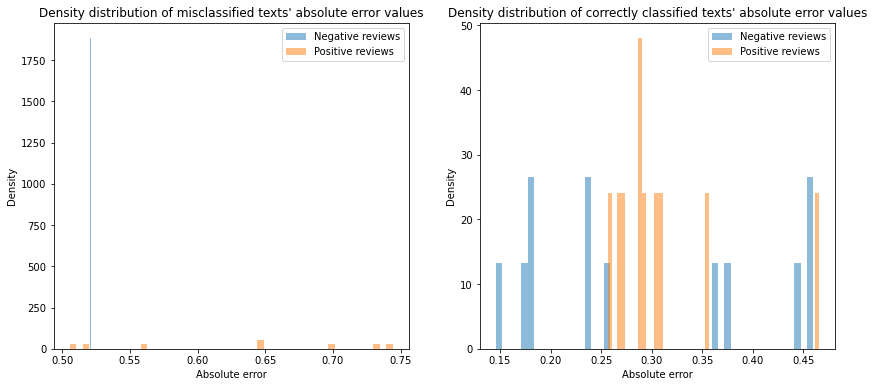

In [ ]:
plot_absolute_error(rf_df)

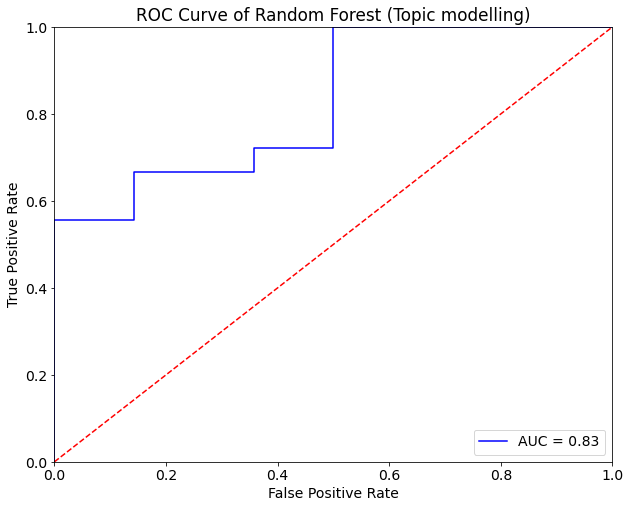

In [ ]:
rf_auc = plot_auc(test_df, rfmodel.predict_proba(X_test)[:,1], "Random Forest (Topic modelling)")

In [ ]:
rf_accuracy = accuracy_score(test_df.Recommended.values, rf_prediction)
summary_df = summary_df.append({'Model': 'Random Forest', 
                                'Accuracy': rf_accuracy,
                                'AUC': rf_auc}, ignore_index=True)

### 4.2.3 Logistic Regression  <a class="anchor" id="chapter4.2.3"></a>

In [ ]:
param_grid = {  
              'C': [0.5, 1, 5, 10],
              'solver': ['lbfgs', 'liblinear', 'sag', 'saga'] 
              }
lrmodel = LogisticRegression(random_state=0)

CV_lrmodel = GridSearchCV(estimator=lrmodel, param_grid=param_grid, 
                          cv=5)
CV_lrmodel.fit(X_train, train_df.Recommended.values) 
print(CV_lrmodel.best_params_)

lrmodel = lrmodel.set_params(**CV_lrmodel.best_params_) 
lrmodel.fit(X_train, train_df.Recommended.values)

lr_prediction = lrmodel.predict(X_test)
print(classification_report(test_df.Recommended.values, lr_prediction))

{'C': 1, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.56      0.71      0.63        14
           1       0.71      0.56      0.63        18

    accuracy                           0.62        32
   macro avg       0.63      0.63      0.63        32
weighted avg       0.64      0.62      0.63        32



In [ ]:
lr_df = error_analysis(test_df,
                       lr_prediction, 
                       prediction_prob=lrmodel.predict_proba(X_test)[:,1])

Distribution of misclassified texts:
 1    8
0    4
Name: Recommended, dtype: int64


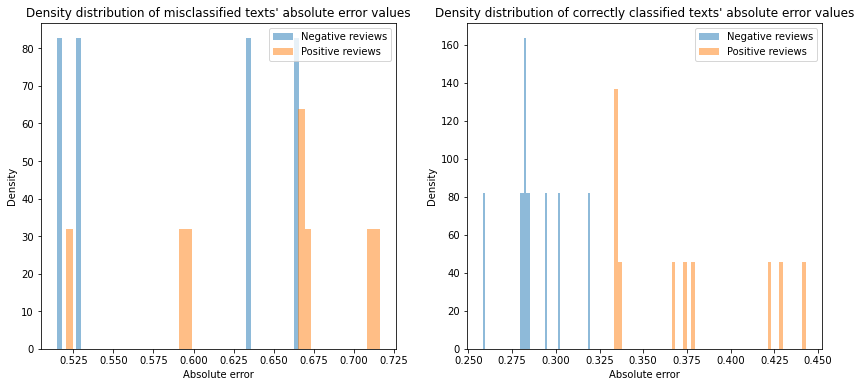

In [ ]:
plot_absolute_error(lr_df)

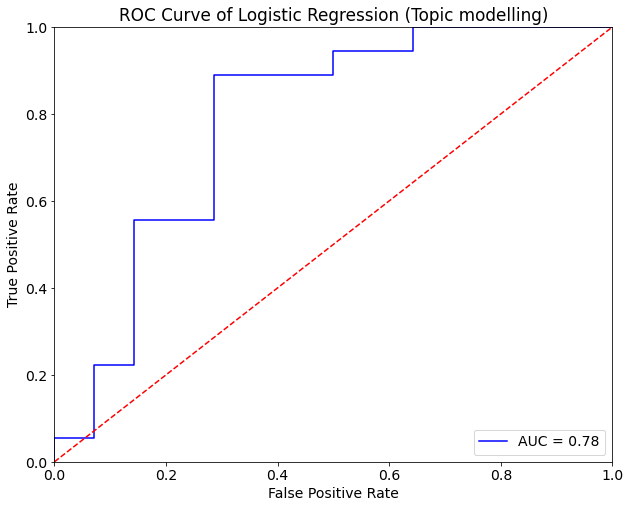

In [ ]:
lr_auc = plot_auc(test_df, lrmodel.predict_proba(X_test)[:,1], "Logistic Regression (Topic modelling)")

In [ ]:
lr_accuracy = accuracy_score(test_df.Recommended.values, lr_prediction)
summary_df = summary_df.append({'Model': 'Logistic Regression', 
                                'Accuracy': lr_accuracy,
                                'AUC': lr_auc}, ignore_index=True)

### 4.2.4 Gradient Boosting  <a class="anchor" id="chapter4.2.4"></a>

In [ ]:
param_grid = {  
              'n_estimators': [100, 150, 200],
              'learning_rate': [0.0075, 0.01, 0.2] 
              }

gbmodel = GradientBoostingClassifier()
CV_gbmodel = GridSearchCV(estimator=gbmodel, param_grid=param_grid, 
                          cv=5)
CV_gbmodel.fit(X_train, train_df.Recommended.values) 
print(CV_gbmodel.best_params_)

gbmodel = gbmodel.set_params(**CV_gbmodel.best_params_) 
gbmodel.fit(X_train, train_df.Recommended.values)

gb_prediction = gbmodel.predict(X_test)
print(classification_report(test_df.Recommended.values, gb_prediction))

{'learning_rate': 0.0075, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        14
           1       0.88      0.78      0.82        18

    accuracy                           0.81        32
   macro avg       0.81      0.82      0.81        32
weighted avg       0.82      0.81      0.81        32



In [ ]:
gb_df = error_analysis(test_df,
                       gb_prediction, 
                       prediction_prob=gbmodel.predict_proba(X_test)[:,1])

Distribution of misclassified texts:
 1    4
0    2
Name: Recommended, dtype: int64


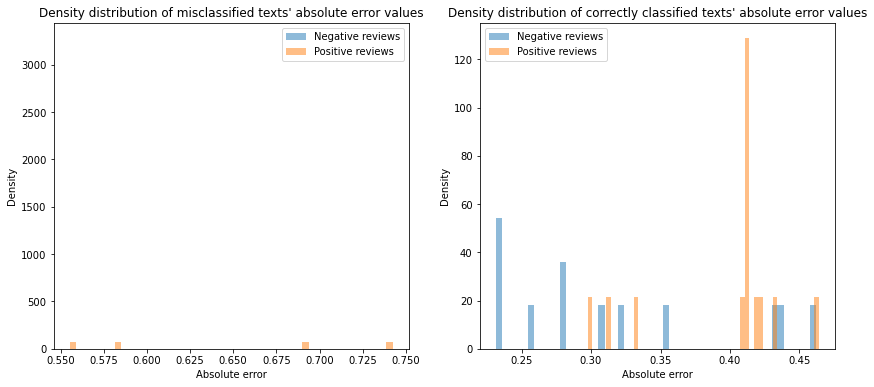

In [ ]:
plot_absolute_error(gb_df)

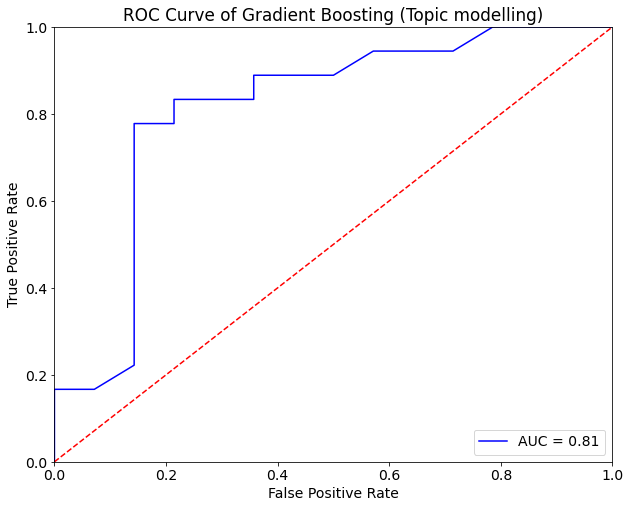

In [ ]:
gb_auc = plot_auc(test_df, gbmodel.predict_proba(X_test)[:,1], "Gradient Boosting (Topic modelling)")

In [ ]:
gb_accuracy = accuracy_score(test_df.Recommended.values, gb_prediction)
summary_df = summary_df.append({'Model': 'Gradient Boosting Classifier', 
                                'Accuracy': gb_accuracy,
                                'AUC': gb_auc}, ignore_index=True)

### 4.2.5 Neural Network  <a class="anchor" id="chapter4.2.5"></a>

In [ ]:
param_grid = {
              'solver': ["lbfgs", "sgd", "adam"],
              'learning_rate': ['constant', 'invscaling', 'adaptive'],
              'hidden_layer_sizes': [25, 50, 100],
              }

nnmodel = MLPClassifier(random_state=0)
CV_nnmodel = GridSearchCV(estimator=nnmodel, param_grid=param_grid, 
                          cv=5)
CV_nnmodel.fit(X_train, train_df.Recommended.values) 
print(CV_nnmodel.best_params_)

nnmodel = nnmodel.set_params(**CV_nnmodel.best_params_) 
nnmodel.fit(X_train, train_df.Recommended.values)

nn_prediction = nnmodel.predict(X_test)
print(classification_report(test_df.Recommended.values, nn_prediction))

{'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.63      0.86      0.73        14
           1       0.85      0.61      0.71        18

    accuracy                           0.72        32
   macro avg       0.74      0.73      0.72        32
weighted avg       0.75      0.72      0.72        32



In [ ]:
nn_df = error_analysis(test_df,
                       nn_prediction, 
                       prediction_prob=nnmodel.predict_proba(X_test)[:,1])

Distribution of misclassified texts:
 1    7
0    2
Name: Recommended, dtype: int64


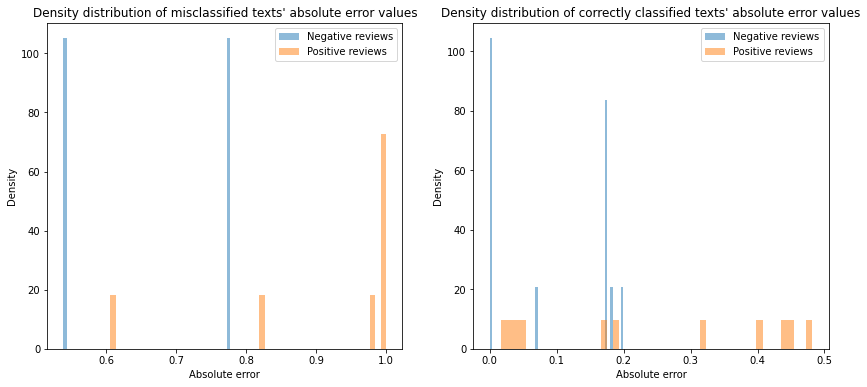

In [ ]:
plot_absolute_error(nn_df)

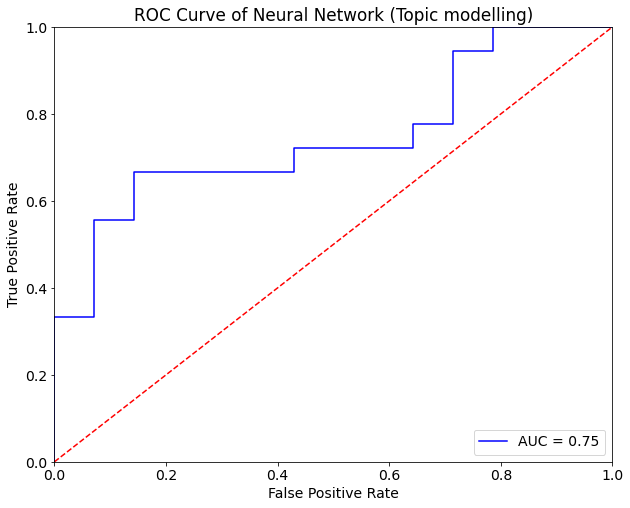

In [ ]:
nn_auc = plot_auc(test_df, nnmodel.predict_proba(X_test)[:,1], "Neural Network (Topic modelling)")

In [ ]:
nn_accuracy = accuracy_score(test_df.Recommended.values, nn_prediction)
summary_df = summary_df.append({'Model': 'Neural Network Classifier', 
                                'Accuracy': nn_accuracy,
                                'AUC': nn_auc}, ignore_index=True)

### 4.2.6 K Nearest Neighbors  <a class="anchor" id="chapter4.2.6"></a>

In [ ]:
param_grid = {
              'n_neighbors': [3, 5, 7],
              'algorithm': ['auto', 'brute', 'ball_tree', 'kd_tree'],
              }

knnmodel = KNeighborsClassifier()
CV_knnmodel = GridSearchCV(estimator=knnmodel, param_grid=param_grid, 
                          cv=5)
CV_knnmodel.fit(X_train, train_df.Recommended.values) 
print(CV_knnmodel.best_params_)

knnmodel = knnmodel.set_params(**CV_knnmodel.best_params_)
knnmodel.fit(X_train, train_df.Recommended.values)

knn_prediction = knnmodel.predict(X_test)
print(classification_report(test_df.Recommended.values, knn_prediction))

{'algorithm': 'auto', 'n_neighbors': 3}
              precision    recall  f1-score   support

           0       0.62      0.93      0.74        14
           1       0.91      0.56      0.69        18

    accuracy                           0.72        32
   macro avg       0.76      0.74      0.72        32
weighted avg       0.78      0.72      0.71        32



In [ ]:
knn_df = error_analysis(test_df,
                        knn_prediction,
                        prediction_prob=knnmodel.predict_proba(X_test)[:,1])

Distribution of misclassified texts:
 1    8
0    1
Name: Recommended, dtype: int64


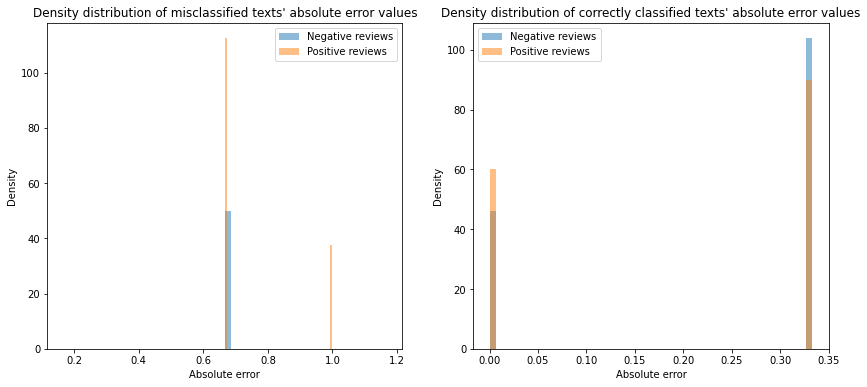

In [ ]:
plot_absolute_error(knn_df)

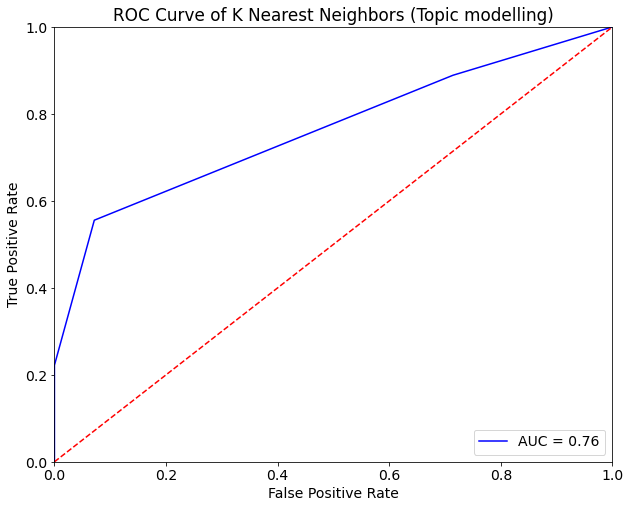

In [ ]:
knn_auc = plot_auc(test_df, knnmodel.predict_proba(X_test)[:,1], "K Nearest Neighbors (Topic modelling)")

In [ ]:
knn_accuracy = accuracy_score(test_df.Recommended.values, knn_prediction)
summary_df = summary_df.append({'Model': 'K Nearest Neighbors', 
                                'Accuracy': knn_accuracy,
                                'AUC': knn_auc}, ignore_index=True)

### 4.2.7 Linear Discriminant Analysis  <a class="anchor" id="chapter4.2.7"></a>

In [ ]:
param_grid = {
              'solver': ['svd', 'lsqr', 'eigen'],
              }

ldamodel = LinearDiscriminantAnalysis()
CV_ldamodel = GridSearchCV(estimator=ldamodel, param_grid=param_grid, 
                          cv=5)
CV_ldamodel.fit(X_train, train_df.Recommended.values) 
print(CV_ldamodel.best_params_)

ldamodel = ldamodel.set_params(**CV_ldamodel.best_params_)
ldamodel.fit(X_train, train_df.Recommended.values)

lda_prediction = ldamodel.predict(X_test)
print(classification_report(test_df.Recommended.values, lda_prediction))

{'solver': 'svd'}
              precision    recall  f1-score   support

           0       0.58      0.79      0.67        14
           1       0.77      0.56      0.65        18

    accuracy                           0.66        32
   macro avg       0.67      0.67      0.66        32
weighted avg       0.69      0.66      0.65        32



In [ ]:
lda_df = error_analysis(test_df,
                        lda_prediction, 
                        prediction_prob=ldamodel.predict_proba(X_test)[:,1])

Distribution of misclassified texts:
 1    8
0    3
Name: Recommended, dtype: int64


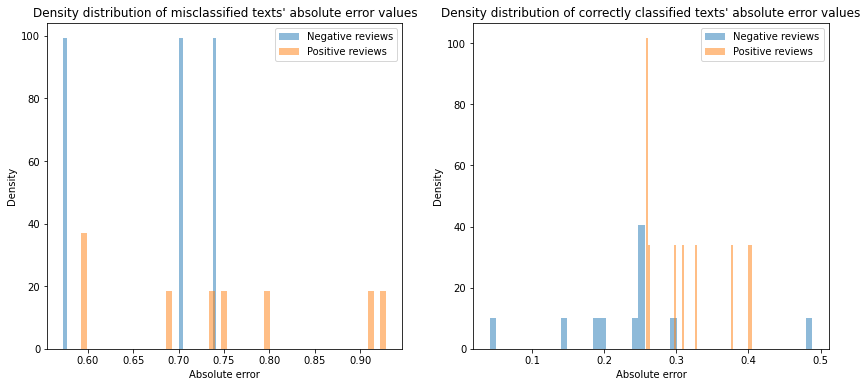

In [ ]:
plot_absolute_error(lda_df)

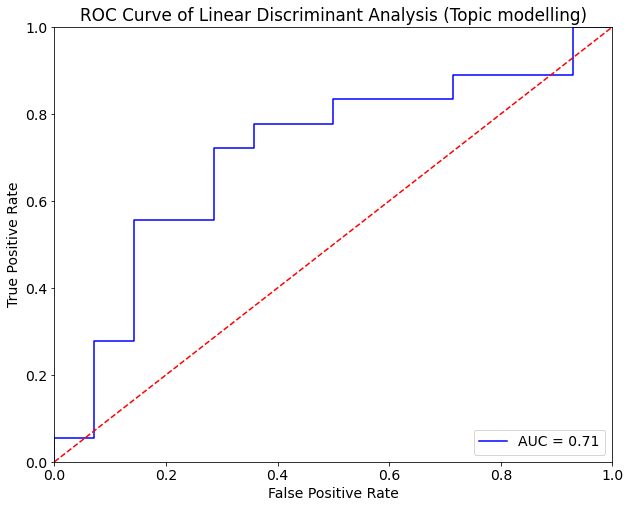

In [ ]:
lda_auc = plot_auc(test_df, ldamodel.predict_proba(X_test)[:,1], "Linear Discriminant Analysis (Topic modelling)")

In [ ]:
lda_accuracy = accuracy_score(test_df.Recommended.values, lda_prediction)
summary_df = summary_df.append({'Model': 'Linear Discriminant Analysis', 
                                'Accuracy': lda_accuracy,
                                'AUC': lda_auc}, ignore_index=True)

## 4.3 Performance summary  <a class="anchor" id="chapter4.3"></a>

In [ ]:
summary_df

,Model,Accuracy,AUC,Avg_perf
0,Support Vector Classifier,0.71875,NaN,0.718750
1,Random Forest,0.68750,0.825397,0.756448
2,Logistic Regression,0.62500,0.781746,0.703373
3,Gradient Boosting Classifier,0.81250,0.811508,0.812004
4,Neural Network Classifier,0.71875,0.746032,0.732391
5,K Nearest Neighbors,0.71875,0.761905,0.740327
6,Linear Discriminant Analysis,0.65625,0.706349,0.681300


In [ ]:
display(summary_df.sort_values("Accuracy", ascending=False))

,Model,Accuracy,AUC
3,Gradient Boosting Classifier,0.81250,0.811508
0,Support Vector Classifier,0.71875,NaN
4,Neural Network Classifier,0.71875,0.746032
5,K Nearest Neighbors,0.71875,0.761905
1,Random Forest,0.68750,0.825397
6,Linear Discriminant Analysis,0.65625,0.706349
2,Logistic Regression,0.62500,0.781746


In [ ]:
summary_df.to_csv("Topic_classification_summary.csv", index=False)

In [ ]:
summary_df['Avg_perf'] = summary_df.mean(axis=1)
display(summary_df.sort_values("Avg_perf", ascending=False))

,Model,Accuracy,AUC,Avg_perf
3,Gradient Boosting Classifier,0.81250,0.811508,0.812004
1,Random Forest,0.68750,0.825397,0.756448
5,K Nearest Neighbors,0.71875,0.761905,0.740327
4,Neural Network Classifier,0.71875,0.746032,0.732391
0,Support Vector Classifier,0.71875,NaN,0.718750
2,Logistic Regression,0.62500,0.781746,0.703373
6,Linear Discriminant Analysis,0.65625,0.706349,0.681300


From the summary table above, it can seen that the **Gradient Boosting** model has the best performance both in terms of accuracy and in terms of AUC.

### 4.3.1 Feature importance analysis <a class="anchor" id="chapter4.3.1"></a>

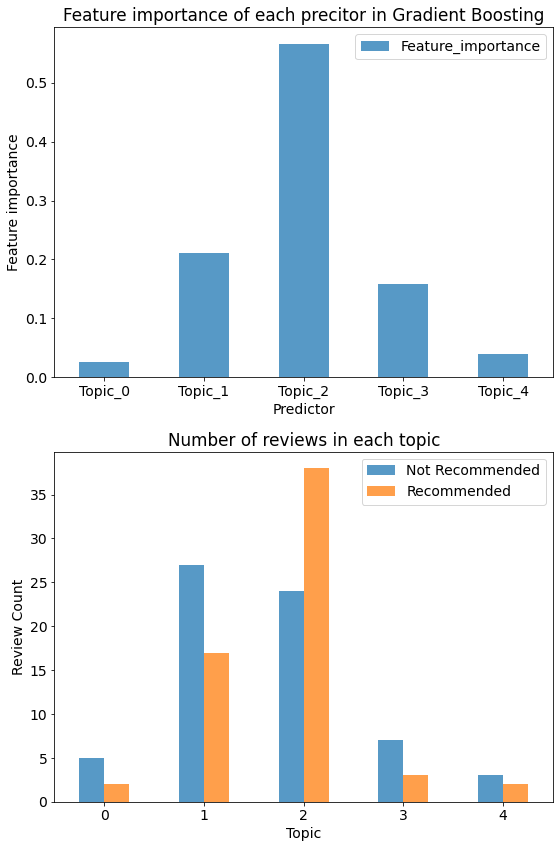

In [ ]:
gb_fi = pd.DataFrame(columns=['Predictor', 'Feature_importance'])
gb_fi['Predictor'] = ['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4']
gb_fi['Feature_importance'] = gbmodel.feature_importances_
gb_fi.set_index("Predictor", inplace=True)

plt.rcParams["figure.figsize"] = (8,12)
fig, ax = plt.subplots(2, 1)
# gb_fi.sort_values("Feature_importance", ascending=False).plot.bar(rot=0)
gb_fi.plot.bar(ax=ax[0], rot=0, alpha=0.75)
ax[0].set_ylabel("Feature importance")
ax[0].set_title("Feature importance of each precitor in Gradient Boosting")

topic_pivot.plot.bar(ax=ax[1], rot=0, alpha=0.75)
ax[1].set_ylabel("Review Count")
ax[1].set_title("Number of reviews in each topic")

plt.tight_layout()
plt.savefig("Gradient_Boosting_fi.png", pad_inches=0.05, dpi=1000)
plt.show()

By comparing the feature importance level and the distribution of positive/negative reviews of each topic for the Gradient Boosting model, it can be seen that they are closly related to each other. To be more specific, the higher the number of reviews within the topic, the higher importance it has in the classifier model. This is reasonable, since a connection is more unlikely to be made if there are only a few supporting samples.

When experimenting with the number of topics and the model configurations, it is also found that the model performance is relatively sensitive to the changes in the topics chosen. Given that the total number of samples is relatively small, and therefore some of the topics only have very few data points, this is reasonable.

### 4.3.2 Further error analysis: misclassified texts by best model <a class="anchor" id="chapter4.3.2"></a>

In [ ]:
# Select all sentences from the misclassified texts in Gradient Boosting with highest absolute errors
sentiment_map = {1: 'positive', 0: 'negative'}

gb_df = gb_df.sort_values('Absolute_error', ascending=False).reset_index(drop=True)
i = 0
while i<6:
    topic = gb_df.at[i, 'Topic']
    positive_pct = round(100 * topic_pivot.at[topic, "Recommended"] / topic_pivot.loc[topic, :].sum(), 2)
    
    col_name = "topic_" + str(topic) + "_prob"
    predict_prob = gb_df.at[i, col_name]
    
    true_label = gb_df.at[i, 'Recommended']
    print(f'\nSample {i}: \nSentiment is {sentiment_map[true_label]}'
          +f'\nClassified as Topic {topic} with a probability of {round(100*predict_prob, 2)}%\n'
          +f'Within this topic {positive_pct}% of the texts are positive.\n')
    print(error_samples[i])
    i += 1


Sample 0: 
Sentiment is positive
Classified as Topic 1 with a probability of 98.98%
Within this topic 61.36% of the texts are positive.

probably the best amongst the cheap flight carriers. most comfortable staff are good and when there is a problem they will actually try to resolve it. despite being a cheap airline they treat their passengers as people and not as cattle as is the norm with other similar airlines. just stay away from the german wings credit card! this is not run by german wings but an independent company. this is a real pain!

Sample 1: 
Sentiment is positive
Classified as Topic 4 with a probability of 58.95%
Within this topic 60.0% of the texts are positive.

cgn-zrh. despite the sudden snowfall at their cologne hub germanwings managed to keep their operations moving reasonably efficiently. waiting pax were kept informed and when the delayed aircraft came in from leipzig it was turned around in less than 15 minutes. the aircraft seemed almost new and was less than ha

- Half of the misclassified texts are categorized into a topic that has a majority of reviews with the opposite labels, which can be the reason why the model is confused and therefore classified the wrong sentiment.
- It is hard to discover other patterns regarding the misclassified texts of the model. Moreover, since the model utilizes topic probabilities, one cannot anlayze the texts simply from the perspectives of semantics. However, it is possible that the mixture of word usage (positive and negative words) in the same review might confuse the model outputs and results in the high sensitivity of the model performance.